In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ehl_data.csv')

In [3]:
df['Legal_Requirements'].value_counts()

Legal_Requirements
HIPAA Compliance              779
GDPR Compliance               747
International Standards       708
Local Data Protection Laws    702
Name: count, dtype: int64

### Understanding the Dataset & Data Cleaning

In [4]:
df.head()

,Patient_ID,Patient_Name,Date_of_Birth,Gender,Legal_Requirements,Privacy_Regulations,Data_Ownership,Security_Risks,Access_Control,Punishments_for_Violations,Proprietary_Tools,User_Access_Procedures,Last_Visit
0,1881,Andrew Clark,1971-07-04,Female,HIPAA Compliance,Confidentiality Agreements,Healthcare Provider,Unauthorized Access,Discretionary Access Control,Fines,Secure Messaging Platforms,Access Logs,2022-11-25
1,2899,Jonathan Barajas,1937-11-24,Male,GDPR Compliance,Anonymization,Shared,Data Corruption,Discretionary Access Control,Revocation of Access,Proprietary EHR Systems,Two-Factor Authentication,2023-01-02
2,1204,Kevin King,1942-01-02,Male,International Standards,Confidentiality Agreements,Patient,Data Breach,Discretionary Access Control,Revocation of Access,Secure Messaging Platforms,Access Logs,2023-10-25
3,2407,Hannah Horn,1944-11-18,Female,International Standards,Anonymization,Patient,Unauthorized Access,Discretionary Access Control,Fines,Secure Messaging Platforms,Secure Login,2023-01-11
4,966,Jill Harris,1951-07-22,Male,HIPAA Compliance,Data Encryption Standards,Shared,Data Breach,Attribute-Based Access Control,Fines,Secure Messaging Platforms,User Training,2023-09-28


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Patient_ID                  2936 non-null   int64 
 1   Patient_Name                2936 non-null   object
 2   Date_of_Birth               2936 non-null   object
 3   Gender                      2936 non-null   object
 4   Legal_Requirements          2936 non-null   object
 5   Privacy_Regulations         2936 non-null   object
 6   Data_Ownership              2936 non-null   object
 7   Security_Risks              2936 non-null   object
 8   Access_Control              2936 non-null   object
 9   Punishments_for_Violations  2936 non-null   object
 10  Proprietary_Tools           2936 non-null   object
 11  User_Access_Procedures      2936 non-null   object
 12  Last_Visit                  2936 non-null   object
dtypes: int64(1), object(12)
memory usage: 298.3+ KB


In [6]:
print(f"The shape of the data is {df.shape}")

The shape of the data is (2936, 13)


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], format='%Y-%m-%d')
df['Age'] = (pd.Timestamp.now().normalize() - df['Date_of_Birth']).dt.days // 365

df['Legal_Requirements'] = df['Legal_Requirements'].astype('category')
df['Privacy_Regulations'] = df['Privacy_Regulations'].astype('category')
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

df.drop(columns=["Patient_Name"], inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Patient_ID                  2936 non-null   int64         
 1   Date_of_Birth               2936 non-null   datetime64[ns]
 2   Gender                      2936 non-null   int64         
 3   Legal_Requirements          2936 non-null   category      
 4   Privacy_Regulations         2936 non-null   category      
 5   Data_Ownership              2936 non-null   object        
 6   Security_Risks              2936 non-null   object        
 7   Access_Control              2936 non-null   object        
 8   Punishments_for_Violations  2936 non-null   object        
 9   Proprietary_Tools           2936 non-null   object        
 10  User_Access_Procedures      2936 non-null   object        
 11  Last_Visit                  2936 non-null   object      

In [10]:


categorical_columns = [
    'Legal_Requirements', 'Privacy_Regulations', 'Data_Ownership', 
    'Security_Risks', 'Access_Control', 'Punishments_for_Violations', 
    'Proprietary_Tools', 'User_Access_Procedures'
]

#check the unique values in each columns
for i in df[categorical_columns]:
  print(i + '    ',df[categorical_columns][i].unique())

# Define the columns that don't need one-hot encoding
non_categorical_columns = [col for col in df.columns if col not in categorical_columns]
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

encoded_columns = categorical_columns
all_columns = encoded_columns + non_categorical_columns

df_encoded = df[all_columns]

print("Label Encoded Data:")
print(df_encoded.head())


Legal_Requirements     ['HIPAA Compliance', 'GDPR Compliance', 'International Standards', 'Local Data Protection Laws']
Categories (4, object): ['GDPR Compliance', 'HIPAA Compliance', 'International Standards', 'Local Data Protection Laws']
Privacy_Regulations     ['Confidentiality Agreements', 'Anonymization', 'Data Encryption Standards', 'Access Restrictions']
Categories (4, object): ['Access Restrictions', 'Anonymization', 'Confidentiality Agreements', 'Data Encryption Standards']
Data_Ownership     ['Healthcare Provider' 'Shared' 'Patient' 'Healthcare Organization']
Security_Risks     ['Unauthorized Access' 'Data Corruption' 'Data Breach' 'Phishing Attacks']
Access_Control     ['Discretionary Access Control' 'Attribute-Based Access Control'
 'Role-Based Access Control']
Punishments_for_Violations     ['Fines' 'Revocation of Access' 'Legal Action' 'Reputational Damage']
Proprietary_Tools     ['Secure Messaging Platforms' 'Proprietary EHR Systems'
 'Compliance Monitoring Tools' 'Encr

In [11]:
df_encoded['Last_Visit'] = pd.to_datetime(df_encoded['Last_Visit'], format='%Y-%m-%d')

In [12]:
print("\nData Types After Conversion:")
print(df_encoded.dtypes)


Data Types After Conversion:
Legal_Requirements                     int64
Privacy_Regulations                    int64
Data_Ownership                         int64
Security_Risks                         int64
Access_Control                         int64
Punishments_for_Violations             int64
Proprietary_Tools                      int64
User_Access_Procedures                 int64
Patient_ID                             int64
Date_of_Birth                 datetime64[ns]
Gender                                 int64
Last_Visit                    datetime64[ns]
Age                                    int64
dtype: object


In [13]:
print("\nData Summary After Preprocessing:")
print(df_encoded.describe())


Data Summary After Preprocessing:
       Legal_Requirements  Privacy_Regulations  Data_Ownership  \
count         2936.000000          2936.000000     2936.000000   
mean             1.464918             1.488079        1.485695   
min              0.000000             0.000000        0.000000   
25%              0.000000             0.000000        0.000000   
50%              1.000000             1.000000        1.000000   
75%              2.000000             2.000000        2.000000   
max              3.000000             3.000000        3.000000   
std              1.111867             1.116331        1.116303   

       Security_Risks  Access_Control  Punishments_for_Violations  \
count     2936.000000     2936.000000                 2936.000000   
mean         1.543597        0.979564                    1.478542   
min          0.000000        0.000000                    0.000000   
25%          1.000000        0.000000                    0.000000   
50%          2.000000    

In [14]:
df_encoded.head()

,Legal_Requirements,Privacy_Regulations,Data_Ownership,Security_Risks,Access_Control,Punishments_for_Violations,Proprietary_Tools,User_Access_Procedures,Patient_ID,Date_of_Birth,Gender,Last_Visit,Age
0,1,2,1,3,1,0,3,0,1881,1971-07-04,1,2022-11-25,53
1,0,1,3,1,1,3,2,2,2899,1937-11-24,0,2023-01-02,86
2,2,2,2,0,1,3,3,0,1204,1942-01-02,0,2023-10-25,82
3,2,1,2,3,1,0,3,1,2407,1944-11-18,1,2023-01-11,79
4,1,3,3,0,0,0,3,3,966,1951-07-22,0,2023-09-28,73


In [15]:
df_encoded.to_csv('ehl_data_label_encoded.csv', index=False)

## Train the model

In [16]:
df_encoded = pd.read_csv('ehl_data_label_encoded.csv')
# Convert Date_of_Birth and Last_Visit to numeric features
df_encoded['Date_of_Birth'] = pd.to_datetime(df_encoded['Date_of_Birth'])
df_encoded['Last_Visit'] = pd.to_datetime(df_encoded['Last_Visit'])

# Convert dates to the number of days since the earliest date in the dataset
reference_date = pd.to_datetime('1900-01-01')
df_encoded['Days_Since_Birth'] = (df_encoded['Date_of_Birth'] - reference_date).dt.days
df_encoded['Days_Since_Last_Visit'] = (df_encoded['Last_Visit'] - reference_date).dt.days

# Drop the original date columns
df_encoded = df_encoded.drop(columns=['Date_of_Birth', 'Last_Visit'])
X = df_encoded.drop(columns=['Age'])
y = df_encoded['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print(f"Training set features shape: {X_train.shape}")
print(f"Testing set features shape: {X_test.shape}")
print(f"Training set target shape: {y_train.shape}")
print(f"Testing set target shape: {y_test.shape}")


Training set features shape: (2348, 12)
Testing set features shape: (588, 12)
Training set target shape: (2348,)
Testing set target shape: (588,)


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, 456 to 860
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Legal_Requirements          2348 non-null   int64
 1   Privacy_Regulations         2348 non-null   int64
 2   Data_Ownership              2348 non-null   int64
 3   Security_Risks              2348 non-null   int64
 4   Access_Control              2348 non-null   int64
 5   Punishments_for_Violations  2348 non-null   int64
 6   Proprietary_Tools           2348 non-null   int64
 7   User_Access_Procedures      2348 non-null   int64
 8   Patient_ID                  2348 non-null   int64
 9   Gender                      2348 non-null   int64
 10  Days_Since_Birth            2348 non-null   int64
 11  Days_Since_Last_Visit       2348 non-null   int64
dtypes: int64(12)
memory usage: 238.5 KB


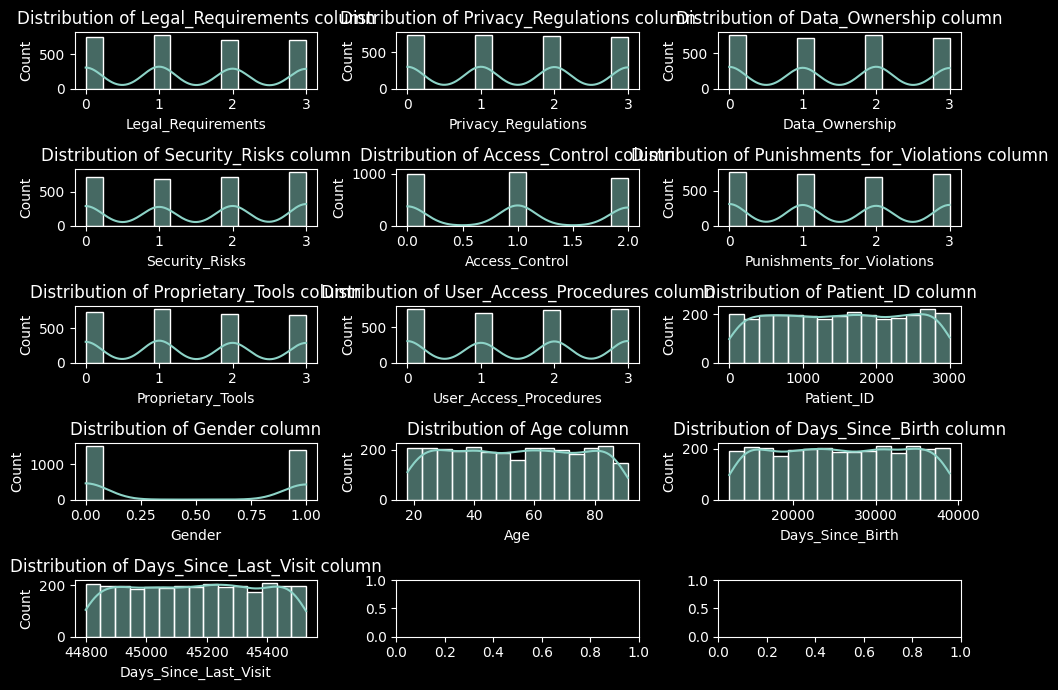

In [18]:
import seaborn as sns
num_col = [col for col in df_encoded.columns if df_encoded[col].dtype != 'object']

#plot the distribution plots for the integers to get information of their distributions
fig, axes = plt.subplots(5, 3, figsize=(10,7))
axes = axes.flatten()

for i, var in enumerate(num_col):
    sns.histplot(df_encoded[var], kde = True, ax=axes[i])
    axes[i].set_title(f"Distribution of {var} column")
plt.tight_layout()
plt.show();

In [21]:
# Initialize the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model to the training data
model.fit(X_train)

# Predict anomaly scores on the test set
anomaly_scores = model.decision_function(X_test)
predictions = model.predict(X_test)

# Convert predictions to a more interpretable format (1 for normal, -1 for anomaly)
predictions = [1 if p == 1 else -1 for p in predictions]

# Add the anomaly scores and predictions to the test set DataFrame
X_test_with_scores = X_test.copy()
X_test_with_scores['Anomaly_Score'] = anomaly_scores
X_test_with_scores['Prediction'] = predictions

print("Anomaly Detection Results:")
print(X_test_with_scores.head())

Anomaly Detection Results:
      Legal_Requirements  Privacy_Regulations  Data_Ownership  Security_Risks  \
1446                   1                    1               3               3   
1451                   2                    0               0               0   
1239                   2                    0               3               0   
177                    0                    2               3               2   
1088                   1                    1               1               2   

      Access_Control  Punishments_for_Violations  Proprietary_Tools  \
1446               0                           1                  0   
1451               2                           3                  3   
1239               0                           3                  3   
177                1                           3                  1   
1088               1                           1                  0   

      User_Access_Procedures  Patient_ID  Gender  Days_Sinc

In [23]:
df_encoded.head()

,Legal_Requirements,Privacy_Regulations,Data_Ownership,Security_Risks,Access_Control,Punishments_for_Violations,Proprietary_Tools,User_Access_Procedures,Patient_ID,Gender,Age,Days_Since_Birth,Days_Since_Last_Visit
0,1,2,1,3,1,0,3,0,1881,1,53,26116,44888
1,0,1,3,1,1,3,2,2,2899,0,86,13841,44926
2,2,2,2,0,1,3,3,0,1204,0,82,15341,45222
3,2,1,2,3,1,0,3,1,2407,1,79,16392,44935
4,1,3,3,0,0,0,3,3,966,0,73,18829,45195


In [24]:
le.classes_

array(['Access Logs', 'Secure Login', 'Two-Factor Authentication',
       'User Training'], dtype=object)

In [30]:
X_test.shape

(588, 12)

In [ ]:
# Initialize and train the Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Predict the classes on the test set
y_pred = model.predict(X_test)

# Get the unique classes from y_test
unique_classes = sorted(set(y_test))

# Print classification report to evaluate the model
print(classification_report(y_test, y_pred, target_names=le.classes_, labels=unique_classes))

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
new_df = pd.read_csv('ehl_data.csv')

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = text.lower()  # Convert to lower case
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Combine the text fields into one column
new_df['Text'] = new_df.apply(lambda row: f"{row['Legal_Requirements']} {row['Privacy_Regulations']} {row['Data_Ownership']} {row['Security_Risks']}", axis=1)
new_df['Text'] = new_df['Text'].apply(preprocess_text)
new_df['Text']

In [ ]:
# Labels
y = new_df['Legal_Requirements']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = label_encoder.classes_

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(new_df['Text'])


In [ ]:
# Step 2: Calculate the prior probability of each class in D
multi_model = MultinomialNB()
multi_model.fit(X, y_encoded)

In [ ]:

# Step 3: Predict the class for a new text T
# Example new text T
T = ["HIPAA data encryption and unauthorized access"]

# Preprocess T
T_preprocessed = [preprocess_text(t) for t in T]
T_vectorized = vectorizer.transform(T_preprocessed)

# Calculate the likelihood and posterior probabilities
predicted_class_index = multi_model.predict(T_vectorized)
predicted_class = label_encoder.inverse_transform(predicted_class_index)

# Output the predicted class
print(f"Predicted class for T: {predicted_class[0]}")

In [ ]:
# To inspect the probability distribution
probs = multi_model.predict_proba(T_vectorized)
prob_df = pd.DataFrame(probs, columns=class_labels)
print(prob_df)

### SVM Model

In [ ]:
ehl = pd.read_csv("/Users/ikubannipaul/Documents/codes/data_science/ml/evaxion/python_analysis/new_ehl_data.csv")

ehl.head()

In [ ]:
ehl["User_Is_Authenticated"].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
ehl.columns

In [ ]:
le = LabelEncoder()
ehl["Gender"] = le.fit_transform(ehl["Gender"])
ehl["Legal_Requirements"] = le.fit_transform(ehl["Legal_Requirements"])
ehl["Privacy_Regulations"] = le.fit_transform(ehl["Privacy_Regulations"])
ehl["Data_Ownership"] = le.fit_transform(ehl["Data_Ownership"])
ehl["Security_Risks"] = le.fit_transform(ehl["Security_Risks"])
ehl["Access_Control"] = le.fit_transform(ehl["Access_Control"])
ehl["Punishments_for_Violations"] = le.fit_transform(ehl["Punishments_for_Violations"])
ehl["Proprietary_Tools"] = le.fit_transform(ehl['Proprietary_Tools'])
ehl["User_Access_Procedures"] = le.fit_transform(ehl["User_Access_Procedures"])

In [ ]:
ehl["User_Is_Authenticated"] = ehl["User_Is_Authenticated"].map({'Not Authenticated':0, 'Authentication':1})

In [ ]:
ehl.head()

In [ ]:
X = ehl.drop(columns=["Date_of_Birth", "Patient_Name", "Patient_ID", "Last_Visit", "User_Is_Authenticated"])
y = ehl["User_Is_Authenticated"]

In [ ]:
#feature selection
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k = 5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

svm = SVC(kernel='linear',)
svm.fit(X_train_selected, y_train)

pre_new = svm.predict(X_test_selected)
acc1 = accuracy_score(y_test, pre_new)

acc1

In [ ]:
from sklearn.feature_selection import mutual_info_classif


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectKBest(mutual_info_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Train Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, n_estimators=200, max_samples='auto', random_state=42)
isolation_forest.fit(X_train_selected)

# Predict on the test set
iso_pre_new = isolation_forest.predict(X_test_selected)

# Convert predictions to binary labels (1 for inliers, 0 for outliers)
iso_pre_new_binary = [1 if x == 1 else 0 for x in iso_pre_new]

# Convert y_test to binary labels (assuming y_test contains 1 for inliers and 0 for outliers)
y_test_binary = [1 if x == 1 else 0 for x in y_test]

# Calculate accuracy
acc1 = accuracy_score(y_test_binary, iso_pre_new_binary)

acc1

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using mutual information
selector = SelectKBest(mutual_info_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Hyperparameter tuning for Isolation Forest
param_grid = {
    'contamination': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 0.8, 0.9],
    'max_features': [1.0, 0.8, 0.9]
}

isolation_forest = IsolationForest(random_state=42)
grid_search = GridSearchCV(isolation_forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Best model from grid search
best_isolation_forest = grid_search.best_estimator_

# Predict on the test set
iso_pre_new = best_isolation_forest.predict(X_test_selected)

# Convert predictions to binary labels (1 for inliers, 0 for outliers)
iso_pre_new_binary = [1 if x == 1 else 0 for x in iso_pre_new]

# Convert y_test to binary labels (assuming y_test contains 1 for inliers and 0 for outliers)
y_test_binary = [1 if x == 1 else 0 for x in y_test]

# Calculate accuracy
acc3 = accuracy_score(y_test_binary, iso_pre_new_binary)
acc3



In [ ]:
svm_conf = confusion_matrix(pre_new, y_test)
print(f"Confusion Matrix For {svm_conf}")

In [ ]:
sns.heatmap(svm_conf, annot=False)
plt.title('Confusion Matrix of SVM')

In [ ]:

y_prob_svm = svm.predict_proba(X_test)[:,1]

In [ ]:
#Evaluate SVM model
def calc_spec_sens(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp/(tp + fn) 
    specificity = tn/(tn + fp)
    return sensitivity, specificity
# sens_svm , spec_svm = calc_spec_sens(y_test, pre_new)
svm_auc = roc_auc_score(y_test, )


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label = 'ROC curve (AUC = {:.2f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic (ROC) Curve for SVM")
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
model = dt.fit(X_train, y_train)
pre4 = model.predict(X_test)
acc = accuracy_score(pre4, y_test)
print(acc)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Feature selection
selector = SelectKBest(chi2, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_selected, y_train)

# Predict on the test set
nb_pre_new = naive_bayes.predict(X_test_selected)

# Calculate accuracy
acc2 = accuracy_score(y_test, nb_pre_new)

acc2

In [ ]:
X_test

In [ ]:
y_prob_nb = naive_bayes.predict_proba(X_test)[:,1]
y_prob_nb

In [ ]:
import pickle
pickle.dump(isolation_forest, open('isolation_forest.pkl', 'wb'))
pickle.dump(svm, open('svm.pkl', 'wb'))
pickle.dump(naive_bayes, open('naive_bayes.pkl', 'wb'))


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, nb_pre_new)

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

In [ ]:
# Calculate confusion matrix
cm_iso = confusion_matrix(y_test_binary, iso_pre_new_binary)

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Isolation Forest Model')
plt.show()

acc1

In [ ]:
#feature selection
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k = 5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

svm = SVC(kernel='linear', C=1)
svm.fit(X_train_selected, y_train)

pre_new = svm.predict(X_test_selected)
acc1 = accuracy_score(y_test, pre_new)

acc1

In [ ]:
#feature selection
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k = 5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

svm = SVC(kernel='linear', C=1)
svm.fit(X_train_selected, y_train)

pre_new = svm.predict(X_test_selected)
acc1 = accuracy_score(y_test, pre_new)

acc1